In [130]:
from abc import ABC, abstractmethod
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [184]:
class BaseState(ABC):
    '''状态基类'''
    def __init__(self, cwnd, ssthresh, dupACKcount):
        self.cwnd = cwnd
        self.ssthresh = ssthresh
        self.dupACKcount = dupACKcount
        
        self.actions = {
            'dupACK': self.act_dup,
            'newACK': self.act_new,
            'timeout': self.act_timeout,
        }
        
    def __call__(self, event):
        return self.actions[event]()
    
    @abstractmethod
    def act_dup(self):
        pass
    
    @abstractmethod
    def act_new(self):
        pass
    
    @abstractmethod
    def act_timeout(self):
        pass
    

class SlowStartState(BaseState):
    '''慢启动状态类'''
    def act_dup(self):
        self.dupACKcount += 1
        
        new_state = None
        if self.dupACKcount == 3:
            self.ssthresh = int(self.cwnd / 2)
            self.cwnd = self.ssthresh + 3
            new_state =  FastRecoveryState(self.cwnd, self.ssthresh, self.dupACKcount)
        
        return new_state, self.cwnd, self.ssthresh
    
    def act_new(self):
        self.cwnd *= 2
        self.dupACKcount = 0
        
        new_state = None
        if self.cwnd >= self.ssthresh:
            self.cwnd = self.ssthresh
            new_state = CongestionAvoidState(self.cwnd, self.ssthresh, self.dupACKcount)
            
        return new_state, self.cwnd, self.ssthresh
    
    def act_timeout(self):
        self.ssthresh = int(self.cwnd / 2)
        self.cwnd = 1
        self.dupACKcount = 0
        
        return None, self.cwnd, self.ssthresh
        
        
class CongestionAvoidState(BaseState):
    '''拥塞避免状态类'''
    def act_dup(self):
        self.dupACKcount += 1
        
        new_state = None
        if self.dupACKcount == 3:
            self.ssthresh = int(self.cwnd / 2)
            self.cwnd = self.ssthresh + 3
            new_state =  FastRecoveryState(self.cwnd, self.ssthresh, self.dupACKcount)
        
        return new_state, self.cwnd, self.ssthresh
    
    def act_new(self):
        self.cwnd += 1
        self.dupACKcount = 0
                    
        return None, self.cwnd, self.ssthresh
    
    def act_timeout(self):
        self.ssthresh = int(self.cwnd / 2)
        self.cwnd = 1
        self.dupACKcount = 0
        
        new_state = SlowStartState(self.cwnd, self.ssthresh, self.dupACKcount)
        
        return new_state, self.cwnd, self.ssthresh
    
    
class FastRecoveryState(BaseState):
    '''快速恢复状态类'''
    def act_dup(self):
        self.cwnd += 1
        
        return None, self.cwnd, self.ssthresh
    
    def act_new(self):
        self.cwnd = self.ssthresh
        self.dupACKcount= 0
        
        new_state = CongestionAvoidState(self.cwnd, self.ssthresh, self.dupACKcount)
                    
        return new_state, self.cwnd, self.ssthresh
    
    def act_timeout(self):
        self.ssthresh = int(self.cwnd / 2)
        self.cwnd = 1
        self.dupACKcount = 0
        
        new_state = SlowStartState(self.cwnd, self.ssthresh, self.dupACKcount)
        
        return new_state, self.cwnd, self.ssthresh


In [208]:
class CongestionControlSimulator(object):
    '''模拟器类'''
    def __init__(self, cwnd=1, ssthresh=16, dupACKcount=0):
        
        self.state = SlowStartState(cwnd, ssthresh, dupACKcount)
        
        data = pd.DataFrame([[cwnd, ssthresh]], [0], columns=["cwnd", "ssthresh"])
        
        self.history = data
            
    def run(self, events):
        
        cwnds = []
        ssthreshs = []
        
        for index, event in enumerate(events):
            state, cwnd, ssthresh = self.state(event)
            
            cwnds.append(cwnd)
            ssthreshs.append(ssthresh)
            
            if state is not None:
                self.state = state
                
        self.history = self.history.append(pd.DataFrame({'cwnd':cwnds, 'ssthresh':ssthreshs}), ignore_index=True)

In [213]:
simulator = CongestionControlSimulator()

events = ['newACK'] * 9 + ['dupACK'] * 3 + ['newACK'] * 8 + ['timeout'] + ['newACK'] * 5

simulator.run(events)

Text(0.5, 0, 'Transmission Round')

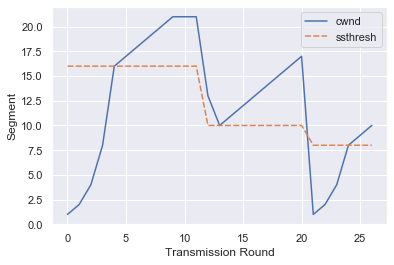

In [214]:
sns.set(style="darkgrid")

sns.lineplot(data=simulator.history)
plt.ylabel("Segment")
plt.xlabel("Transmission Round")